In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import math
import random

### Loading Image Dataset

shape of image_digit_list is [[[64*64 image ndarray],digit(0/1)]]


In [2]:
digit_direcroty_image_list = []
for i in range(2):
    mypath = os.path.join('BanglaDigitZeroOne', str(i))
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    digit_direcroty_image_list.append([i, mypath, onlyfiles])

image_digit_list = []
for item in digit_direcroty_image_list:
    digit = item[0]
    digit_directory = item[1]
    image_list = item[2]
    for image in image_list:
        path = os.path.join(digit_directory, image)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        resized = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
        image_digit_list.append([resized, digit])
random.shuffle(image_digit_list)

In [3]:
X = [i[0] for i in image_digit_list]  # Image 64*64 ndarray to X
y = [i[1] for i in image_digit_list]  # Image label to y
X = np.array(X)                       # ndarray list to numpy array shape (3964, 64, 64)
y = np.array(y)                       # list to numpy array unranked shape (3964,)
y = y.reshape(1,y.shape[0])           # unranked array to (1, 3964) shaped array

In [4]:
print(X.shape)                       # (3964, 64, 64)
print(y.shape)                       # (1, 3964)

(3964, 64, 64)
(1, 3964)


## Display random image

0


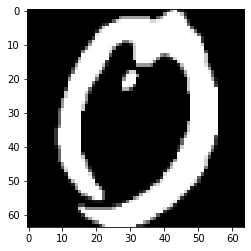

In [5]:
index = 546
print(np.squeeze(y[:, index]))
plt.imshow(X[index], cmap='gray', vmin=0, vmax=255)
plt.show()

### Train Test Split the Dataset

In [6]:
dataset_length = len(X)
train_length = math.ceil(dataset_length*.8)
train_set_x_orig = X[:train_length]          # (3172, 64, 64)
train_set_y = y[:,:train_length]             # (1, 3172)
test_set_x_orig =X[train_length:]            # (792, 64, 64)
test_set_y = y[:,train_length:]              # (1, 792)

### Flatten Dataset

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2],train_set_x_orig.shape[0])     # (3172, 64, 64) ==> (4096, 3172)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2],test_set_x_orig.shape[0])          # (792, 64, 64) ==> (4096, 792)

In [8]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (4096, 3172)
train_set_y shape: (1, 3172)
test_set_x_flatten shape: (4096, 792)
test_set_y shape: (1, 792)


### Normalizing Dataset

In [9]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## General Architecture of the learning algorithm ##

We will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

# Helper Functions

### Sigmoid

In [10]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))    
    return s

### Initializing Parameters
Initialize weights and bias as zero
- dim -- size of the w vector we want (or number of parameters in this case)
- w -- initialized vector of shape (dim, 1)
- b -- initialized scalar (corresponds to the bias)

In [17]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int)) 
    return w,b

### Forward and Backward propagation

Now that our parameters are initialized, we can do the "forward" and "backward" propagation steps for learning the parameters.

Forward Propagation:
- We get X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
def propagate(w, b, X, Y):
    # Saving Dataset Lentgh or Number of examples in m
    m = X.shape[1]
    # Computing activation A or prediction using sigmoid function
    # w of shape (number_of_feature,1) to w.T of shape (1,number_of_feature)
    # w.T(1,number_of_feature) dot X(number_of_features, number_of_examples)
    A = sigmoid(np.dot(w.T,X) + b)
    # Computing Cost Using Computed Activation or Prediction and Original Label based on cost formula
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m
    # Computing Computing Gradients based on derivatives formula
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

### Optimization
- We have initialized your parameters.
- We are also able to compute a cost function and its gradient.
- Now, we want to update the parameters using gradient descent.

Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]        
        # update rule
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w, "b": b}    
    grads = {"dw": dw, "db": db}    
    return params, grads, costs

### Predict

In [14]:
def predict(w, b, X):
    '''  
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)           # Dimentions = (1, m) 

    for i in range(A.shape[1]):        
        Y_prediction[0, i] = 1 if A[0,i] >=0.5 else 0 ## Convert probabilities A[0,i] to actual predictions p[0,i]    
    
    assert(Y_prediction.shape == (1, m))    
    return Y_prediction

## Merge all functions into a model 

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):        
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])
    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 20000, learning_rate = 0.02, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.659264
Cost after iteration 200: 0.645577
Cost after iteration 300: 0.634877
Cost after iteration 400: 0.625757
Cost after iteration 500: 0.617694
Cost after iteration 600: 0.610412
Cost after iteration 700: 0.603743
Cost after iteration 800: 0.597575
Cost after iteration 900: 0.591824
Cost after iteration 1000: 0.586429
Cost after iteration 1100: 0.581343
Cost after iteration 1200: 0.576528
Cost after iteration 1300: 0.571952
Cost after iteration 1400: 0.567590
Cost after iteration 1500: 0.563419
Cost after iteration 1600: 0.559423
Cost after iteration 1700: 0.555584
Cost after iteration 1800: 0.551890
Cost after iteration 1900: 0.548328
Cost after iteration 2000: 0.544887
Cost after iteration 2100: 0.541560
Cost after iteration 2200: 0.538336
Cost after iteration 2300: 0.535210
Cost after iteration 2400: 0.532175
Cost after iteration 2500: 0.529224
Cost after iteration 2600: 0.526352
Cost after iteration 2700: 0.523555
Cost